In [1]:
#!pipenv install treys
#!pipenv install termcolor
#!pipenv install pandas

In [2]:
import PIL.Image
import numpy as np
from typing import Union
from glob import glob
import pandas as pd
import os
from skimage import exposure
#from treys import Card
from termcolor import colored
#from utils import eval_listof_games , debug_listof_games, save_results , load_results
import matplotlib.pyplot as plt


import sys
import math
import cv2 as cv
import numpy as np

import os

# [IAPR][iapr]: Project


**Group ID:** 05

**Author 1 (sciper):** Lavinia Schlyter (284566)
**Author 2 (sciper):** Simon Gilgien (253797)  

**Release date:** 29.04.2022


## Important notes

The assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Introduction

An anonymous card player that we will name Bartick Pruel is willing to improve his poker skills. To do so, he asked our lab to design a tool that will automatically detect the hands of the players around the table. 

---

## 1. Data

To achieve your task, you will be given images that look like this (without the overlay)

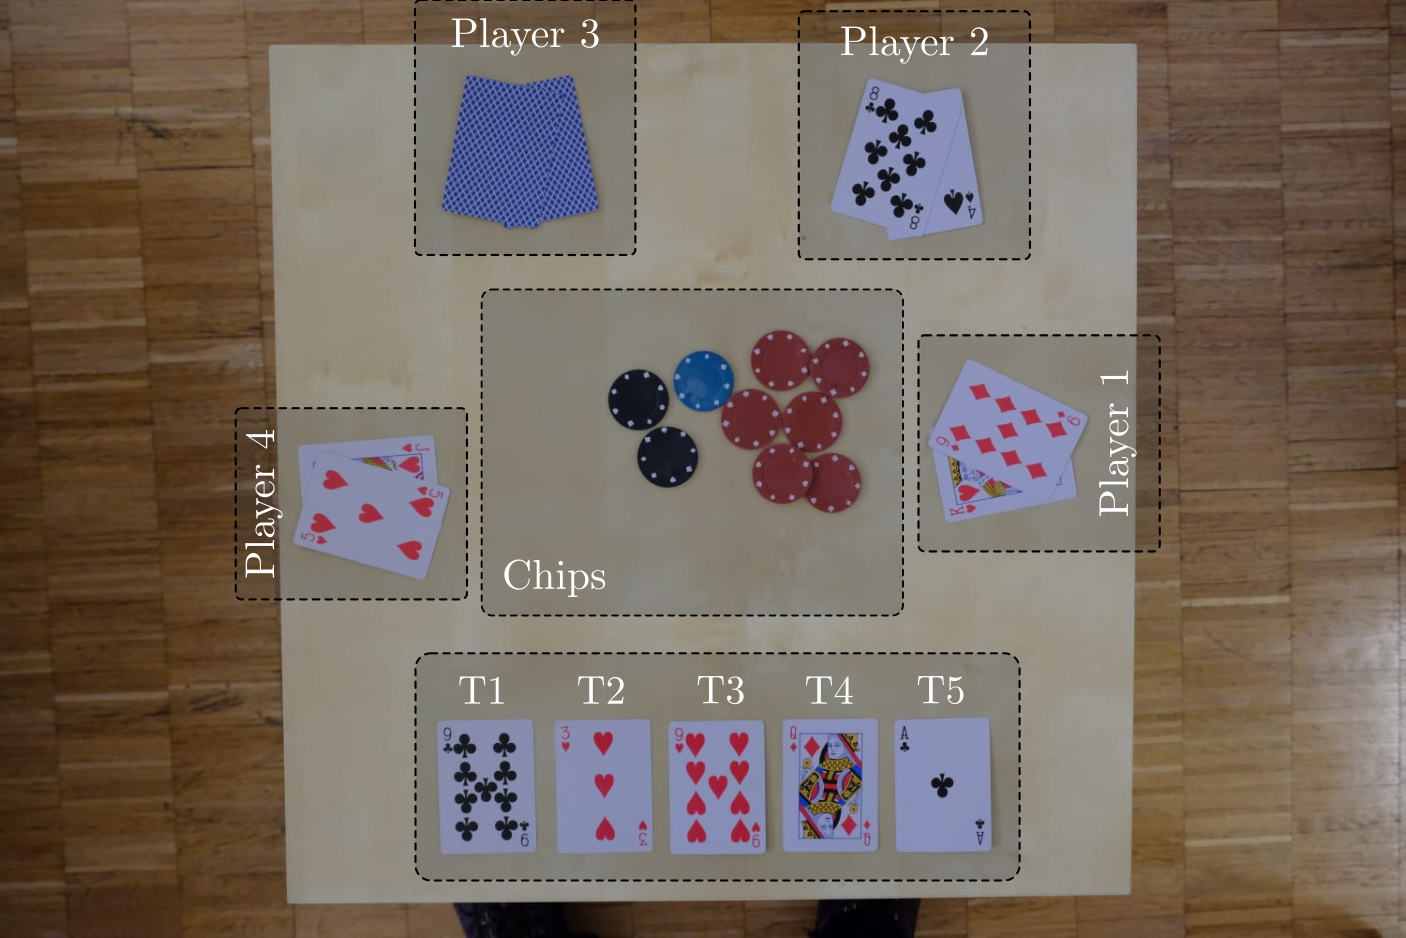


### 1.1. Table layout

The table is divided into 3 main parts:
* **Table cards (T1-T5)**: These cards are shared by every player. They are defined as the flop (T1-T3), the turn (T4) and the river (T5). The table cards are *always* visible.
* **Player cards (P11-P42)**: The cards played by each player (4 pairs). Each player *always* has 2 cards in hand. When a player is not playing, you can see the back of the cards (ex: player 3 here).
* **Chips**: The chips at the center of the table are named the pot.

### 1.2. Cards & Chips

The cards deck are composed of 52 cards split into 4 different colors: (D)imanond, (H)eart, (S)pade, (C)lub. Each color is composed of 13 different cards: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, (J)ack, (Q)ueen, (K)ing.

Th chips can be of 5 different colors: (r)ed, (g)reen, (b)lue, blac(k) or (w)hite.


### 1.3 Structure

You can download the data for the project here: [download data](https://drive.google.com/file/d/1d7rOe88kEK1CEaLvYgNZkxrtKImLVC9X/view)

```
data 
│
└─── image_setup
│    │    back_cards.jpg      # Back of the cards (either blue or red)
│    │    chips.jpg           # Set of chips used (red, green, blue, black, white)
│    │    kings.jpg           # Kings from the 4 colors (diamond, heart, spade, club)
│    │    spades_suits.jpg    # All cards of spades (1 - 10, Jack, Queen, King)
│    │    table.jpg           # Empty table
│    └─── ultimate_test.jpg   # If it works on that image, you would probably end up with a good score
│
└─── train
│    │    train_00.jpg        # Train image 00
│    │    ...
│    │    train_27.jpg        # Train image 27
│    └─── train_labels.csv    # Ground truth of the train set
│
└─── test
     │    test_00.jpg         # Test image 00 (day of the exam only)
     │    ...
     └─── test_xx             # Test image xx (day of the exam only)
```


---

## 2. Tasks


Your task is to predict the following parameters for a set of images.

* **T1** (str): String code of the first card of the flop (far left) 
* **T2** (str): String code of the second card of the flop
* **T3** (str): String code of the third card of the flop
* **T4** (str): String code of the turn
* **T5** (str): String code of the river


* **P11** (str or int): String code of player 1 card 1. Should be 0 if player 1 is not Playing.
* **P12** (str or int): String code of player 1 card 2. Should be 0 if player 1 is not Playing.
* **P21** (str or int): String code of player 2 card 1. Should be 0 if player 2 is not Playing.
* **P22** (str or int): String code of player 2 card 2. Should be 0 if player 2 is not Playing.
* **P31** (str or int): String code of player 3 card 1. Should be 0 if player 3 is not Playing.
* **P32** (str or int): String code of player 3 card 2. Should be 0 if player 3 is not Playing.
* **P41** (str or int): String code of player 4 card 1. Should be 0 if player 4 is not Playing.
* **P42** (str or int): String code of player 4 card 2. Should be 0 if player 5 is not Playing.


* **CR** (int): Number of (r)ed chips in the pot
* **CG** (int): Number of (g)reen chips in the pot
* **CB** (int): Number of (b)lue chips in the pot
* **CK** (int): Number of blac(k) chips in the pot
* **CW** (int): Number of (w)hite chips in the pot


The output is saved using the function **save_results** as presented below.

---
## 3. Evaluation

**Before the exam**
   - Create a zipped folder named **groupid_xx.zip** that you upload on moodle (xx being your group number).
   - Include a **runnable** code (Jupyter Notebook and external files) and your presentation in the zip folder.
   
**The day of the exam**
   - You will be given a **new folder** with few images, but **no ground truth** (csv file).
   - We will ask you to run your pipeline in **real time** and to send us your prediction of the task you obtain with the provided function **save_results**. 
   - On our side, we will compute the performance of your classification algorithm. 
   - To evaluate your method, we will use the **evaluate_game** function presented below. To understand how the provided functions work, please read the documentation of the functions in **utils.py**.
   - **Please make sure your function returns the proper data format to avoid points penalty on the day of the exam**. 
---


## 4. Your code

### 1) Detect table

In [3]:
def open_image(file):
    return cv.cvtColor(cv.imread(file), cv.COLOR_BGR2RGB)

In [4]:
table = open_image("../project_data/image_setup/table.jpg")

In [5]:
def basic_processing(image_array, kernel_size = 201):
    image_array_copy = image_array.copy()
    # Convert to gray
    image_gray = cv.cvtColor(image_array_copy, cv.COLOR_RGB2GRAY)
    
    # Gaussian blur
    image_gray_blur = cv.GaussianBlur(image_gray, (kernel_size,kernel_size), 0)
    return image_gray_blur
    

In [6]:
def canny_filter(image_array, low_thresh = 10, high_thresh = 100, aperature_size = 5, plot_verbose = False):
    edges = cv.Canny(image_array, low_thresh, high_thresh, apertureSize=aperature_size)
    
    if plot_verbose:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(edges);
        
    return edges
    
    

In [7]:
def hough_transform(image_array, edges, rho = 7, theta = np.pi / 90,threshold= 1500, minLineLength = 2000,maxLineGap = 150, plot_verbose = False):
    
    
    linesP = cv.HoughLinesP(image = edges, rho = rho, theta = theta,threshold= threshold, minLineLength = minLineLength, maxLineGap = maxLineGap)
    image_copy = image_array.copy()
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv.line(image_copy, (l[0], l[1]), (l[2], l[3]), (255,0,0), 3, cv.LINE_AA)

    if plot_verbose:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(image_copy)
    return linesP

In [8]:
def extract_corners_square(linesP):
    linesP = np.reshape(linesP, (-1, 2))
    x_top_left = np.min(linesP[(linesP[:,0]<1500) & (linesP[:,1] < 1000)][:,0])
    y_top_left = np.min(linesP[(linesP[:,0]<1500) & (linesP[:,1] < 1000)][:,1])

    x_bot_left = x_top_left
    y_bot_left = np.max(linesP[(linesP[:,0]<1500) & (linesP[:,1] > 3000)][:,1])
    
    x_top_right = np.max(linesP[(linesP[:,0]>4000) & (linesP[:,1] < 1000)][:,0])
    y_top_right = np.min(linesP[(linesP[:,0]>4000) & (linesP[:,1] < 1000)][:,1])
    
    x_bot_right = x_top_right
    y_bot_right = np.max(linesP[(linesP[:,0]>4000) & (linesP[:,1] > 3000)][:,1])
    
    return np.float32([[x_top_left,y_top_left],[x_top_right,y_top_right],[x_bot_left,y_bot_left],[x_bot_right,y_bot_right]])

In [9]:
test_corner_points = False
if test_corner_points:
    table_copy_test = table.copy()
    image_tst = cv.circle(table_copy_test, (1096,250), radius=10, color=(0,255, 0), thickness=100)
    image_tst = cv.circle(image_tst, (1096,3779), radius=10, color=(0,255, 0), thickness=100)
    image_tst = cv.circle(image_tst, (4495,246), radius=10, color=(0,255, 0), thickness=100)
    image_tst = cv.circle(image_tst, (4495,3712), radius=10, color=(0,255, 0), thickness=100)
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(image_tst) 

In [10]:
def perspective_transform(image_array, initial_corners, plot_verbose = False):
    trans_corners = np.float32([[0,0],[3500,0],[0,3500],[3500,3500]])
    M_trans = cv.getPerspectiveTransform(initial_corners,trans_corners)
    image_perspective = cv.warpPerspective(image_array,M_trans,(3500,3500))
    
    if plot_verbose:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(image_perspective) 
        
    return image_perspective

    

In [11]:
def crop_reframe_image(image_array):
    pre_process = basic_processing(image_array)
    canny_edges = canny_filter(pre_process)
    lines_hough = hough_transform(image_array, canny_edges)
    initial_corners = extract_corners_square(lines_hough)
    image_reframed = perspective_transform(image_array, initial_corners)
    return image_reframed
    

In [12]:
table_cropped = crop_reframe_image(table)

table_ref = table_cropped[:, np.r_[200:500, -500:-200]][np.r_[200:1000, -1000:-200]]

#mean_ref = np.mean(cv.cvtColor(table_ref, cv.COLOR_RGB2YCrCb)[:, :, 0])

#table_ref = cv.cvtColor(table_ref, cv.COLOR_RGB2LAB)

table_ref = cv.GaussianBlur(table_ref, (51, 51), 0)

ref_vals, ref_quantiles = [], []
for i in range(3):
    vals, counts = np.unique(np.r_[table_ref[:, :, i].ravel(), []], return_counts=True)
    ref_vals.append(vals)
    ref_quantiles.append(np.cumsum(counts) / table_ref[:, :, i].size)

#table_ycrcb = cv.cvtColor(table_cropped, cv.COLOR_RGB2YCrCb)

#ref_vals, ref_counts = np.unique(table_ycrcb[:, :, 0], return_counts=True)
#ref_quantiles = np.cumsum(ref_counts) / table_ycrcb[:, :, 0].size

def histogram_equalization(image):
    #image = cv.cvtColor(image, cv.COLOR_RGB2YCrCb)
    #image = cv.cvtColor(image, cv.COLOR_RGB2LAB)
    sample = image[:, np.r_[200:500, -500:-200]][np.r_[200:1000, -1000:-200]]
    sample = cv.GaussianBlur(sample, (51, 51), 0)
    
    #mean_sample = np.mean(sample[:, :, 0])
    #diff = mean_sample - mean_ref
    #image[:, :, 0] -= diff.astype(image.dtype)
    #_, image_unique_indices, image_counts = np.unique(image[:, :, 0].ravel(), return_inverse=True, return_counts=True)
    #image_quantiles = np.cumsum(image_counts) / image[:, :, 0].size
    
    #interp_values = np.interp(image_quantiles, ref_quantiles, ref_vals)
    #image[:, :, 0] = interp_values[image_unique_indices].reshape(image.shape[:-1])
    #return cv.cvtColor(image, cv.COLOR_YCrCb2RGB)
    
    for i in range(3):
        sample_values, sample_counts = np.unique(np.r_[sample[:, :, i].ravel(), []], return_counts=True)
        sample_quantiles = np.cumsum(sample_counts) / sample[:, :, i].size
        
        image_quantiles = np.interp(image[:, :, i], sample_values, sample_quantiles, left=0, right=1)
        image[:, :, i] = np.interp(image_quantiles, ref_quantiles[i], ref_vals[i], left=0, right=255)
    
    return image
    return cv.cvtColor(image, cv.COLOR_LAB2RGB)
    
    

In [13]:
train_images_cropped= []# = [crop_reframe_image(open_image(f"../project_data/train/train_{str(i).zfill(2)}.jpg")) for i in range(28)]

In [14]:
force_crop = False
train_images = glob("../project_data/train/*.jpg")
directory = "../project_data/train_crop/"
if not os.path.exists(directory):
    os.makedirs(directory)
for image_file in train_images:
    path = directory + "train_crop_" + image_file.split("_")[-1]
    if force_crop or not os.path.exists(path):
        image_cropped = crop_reframe_image(open_image(image_file))
        cv.imwrite(path, cv.cvtColor(image_cropped, cv.COLOR_RGB2BGR))
        train_images_cropped.append(image_cropped)

In [15]:
test_histogram = False
if test_histogram:
    for im in train_images_cropped:
        im = histogram_equalization(im)
        
        plt.figure()
        plt.imshow(im)

### Set the boundaries for each player

In [16]:
# For cutting bottom cards

train_images_crop = glob("../project_data/train_crop/*.jpg")
CROPPING_FOR_NOTHING = False
if CROPPING_FOR_NOTHING:
    for image_file in train_images_crop:
        im = open_image(image_file)
        cropped_image_bottom = im[2600:3400, 500:3000]
        cropped_image_p1 = im[1100:2200, 2500:-50]
        cropped_image_p4 = im[1300:2300, 0:900]
        cropped_image_p3 = im[0:900, 500:1500]
        cropped_image_p2 = im[0:900, 2000:3000]
        cropped_image_chips = im[950:2600, 900:2500]
        #plt.imshow(cropped_image_chips)
        #plt.show()

### For each of the 3 algorithms to use we crop the image before-hand 
- cropped_image_bottom = im[2600:3400, 500:3000]
- cropped_image_p1 = im[1100:2200, 2500:-50]
- cropped_image_p4 = im[1300:2300, 0:900]
- cropped_image_p3 = im[0:900, 500:1500]
- cropped_image_p2 = im[0:900, 2000:3000]
- cropped_image_chips = im[950:2600, 900:2500]

### Algo 1: Bottom cards

Idea:
- Find edges of cards
- Rescale and redress cards
- For the cards which were not well identified, aka, no rectangle was found, they are cropped grossly and the process is re-iterated

- Isolate number and symbol
- Define card color
- Black and white for symbols with Fourrier 

In [17]:
def isolate_bottom_cards(image, plot_verbose = False):
    
    # Threshold set for positions, in order to detect card order
    threshold_card1 = 500
    threshold_card2 = 1000
    threshold_card3 = 1500
    threshold_card4 = 2000
    threshold_card5 = 2500
    
    # Crop the bottom part of the image
    cropped_image_bottom = image[2600:3400, 500:3000]
    
    # Extract height and width
    (h, w) = cropped_image_bottom.shape[:2]
    
    # Dictionarry for storing cards ((center_x, center_y), (height, width), angle)
    CARDS = {}
    # Function to convert to grayscale + Gaussian blurring
    pre = basic_processing(cropped_image_bottom, kernel_size=15)
    # Detection of edges
    pre_canny_edge = canny_filter(pre, low_thresh = 120, high_thresh = 200)
    
    # Find only the external contours
    contours,_ = cv.findContours(pre_canny_edge.copy(),cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    img_copy = np.copy(cropped_image_bottom)
    # Loop through contours to find best matching one with rectangle (card) of given size
    for cnt in contours:


        rect = cv.minAreaRect(cnt)
        # Center(x,y), (w,h), angle)
        # Check width and heigth to filter as well as angle to avoid any strange rotations (rect[2])
        if ((rect[1][0]>300) & (rect[1][0]<600) & (rect[1][1]>300) & ((rect[2] > 70) | (rect[2] < 20))):
            # Located card in order
            if 0 <= rect[0][0] <= threshold_card1:
                CARDS[0] = rect
            elif threshold_card1 < rect[0][0] <= threshold_card2:
                CARDS[1] = rect
            elif threshold_card2 < rect[0][0] <= threshold_card3:
                CARDS[2] = rect 
            elif threshold_card3 < rect[0][0] <= threshold_card4:
                CARDS[3] = rect 
            elif threshold_card4 < rect[0][0] <= threshold_card5:
                CARDS[4] = rect     
            box = cv.boxPoints(rect)
            box = np.int0(box)
            cv.drawContours(img_copy,[box],0,(0,191,255),10)
            
    if plot_verbose:
        plt.imshow(img_copy)
        
    return CARDS, (h,w), cropped_image_bottom
    
    
def crop_bottom_images(CARD, h,w,cropped_image_bottom, second_run = False, plot_verbose = False):
    
    # Check on whether it is the second time the picture is processed with no success. AKA, edge detection + contour fail
    if ((second_run) & (CARD[1][0] == 650)):
        croped = cropped_image_bottom
    else:
        # Rotate the image with given angle of card and use card coordinates to crop
        M = cv.getRotationMatrix2D((int(CARD[0][0]), int(CARD[0][1])), find_rotation(CARD), 1.0)
        rotated = cv.warpAffine(cropped_image_bottom, M, (w, h))
        croped = rotated[int(CARD[0][1] - max(CARD[1][0],CARD[1][1])/2): int(CARD[0][1] + max(CARD[1][0],CARD[1][1])/2),int(CARD[0][0] - min(CARD[1][0],CARD[1][1])/2): int(CARD[0][0] + min(CARD[1][0],CARD[1][1])/2)]
        
    
    
    if plot_verbose:

        plt.imshow(croped)
        plt.show()
    
    
    return croped
    
    
    
def find_rotation(Card_coord):
    # Function that returns in which way must the card be rotated for straight results 
    if abs(90 - Card_coord[2]) < abs(Card_coord[2]):
        return -(90 - Card_coord[2])
    else:
        return Card_coord[2]
    
def process_not_found_cards(cards):
    not_found_list = []
    y_center_card = 400
    # Add margin for non found cards
    height_card = 650 # True 550
    width_card = 500 # True 390
    x_center_first_card = 360
    x_jump_center = 470
    # Make a list of non found images for processing later on 
    for i in range(5):
        if i not in cards.keys():
            
            not_found_list.append(i)
            # First card not detected
            if i == 0:
                cards[i] = tuple([(x_center_first_card, y_center_card), (height_card, width_card), 0.0])
            else:
                cards[i] = tuple([(max(cards[i-1][0][0],cards[i-1][0][1]) + x_jump_center, y_center_card), (height_card, width_card), 0.0])


    return cards,not_found_list    


def post_processing_not_found(CROPED_CARDS, cards, card_number = 999,plot_verbose = False):
    img_copy = CROPED_CARDS[card_number].copy()
    pre = basic_processing(CROPED_CARDS[card_number], kernel_size=9)
    pre_canny_edge = canny_filter(pre, low_thresh = 90, high_thresh = 250)

    contours,_ = cv.findContours(pre_canny_edge.copy(),cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

    for cnt in contours:


        rect = cv.minAreaRect(cnt)
        if ((rect[1][0]>300) & (rect[1][0]<600) & (rect[1][1]>300) & ((rect[2] > 70) | (rect[2] < 20))):

            #Update card rectangle for more precise measures 
            cards[card_number] = rect

            box = cv.boxPoints(rect)
            box = np.int0(box)
            cv.drawContours(img_copy,[box],0,(0,191,255),10)

    if plot_verbose:

        plt.imshow(img_copy)
        plt.show()
def crop_non_found_card(Croped_cards, cards, plot_verbose = False):
    
    (h, w) = Croped_cards.shape[:2]
    
    return crop_bottom_images(cards, h,w,Croped_cards, second_run =True, plot_verbose = plot_verbose)
            

In [18]:
def identify_bottom_cards(image, plot_verbose = False,plot_verbose_end = False):
    cards, (h,w), cropped_bottom = isolate_bottom_cards(image, plot_verbose= plot_verbose)
    cards, not_found_list = process_not_found_cards(cards)
    CROPED_CARDS = {}
    for card_id in range(5):
        CROPED_CARDS[card_id] = crop_bottom_images(cards[card_id], h, w, cropped_bottom, plot_verbose= plot_verbose)


    # Check for cards that need extra processing 

    for card_id in not_found_list:  
        # Proceed in finer edge detection
        post_processing_not_found(CROPED_CARDS, cards, card_number = card_id ,plot_verbose = plot_verbose)
    for card_id in not_found_list:  
        # Update croping for cards not in list
        CROPED_CARDS[card_id] = crop_non_found_card(CROPED_CARDS[card_id], cards[card_id], plot_verbose = plot_verbose)
    
    if plot_verbose_end:
        fig, axs = plt.subplots(1,5, figsize = (10,8))
        for i in range(5):
            axs[i].imshow(CROPED_CARDS[i])
        plt.show()
            
    return CROPED_CARDS

    

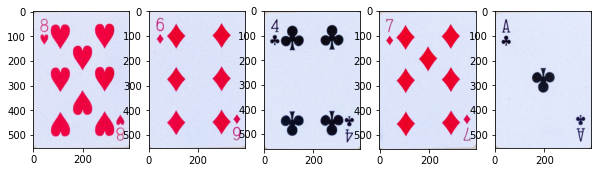

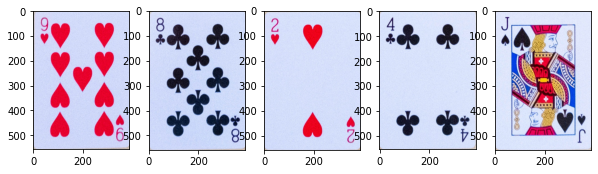

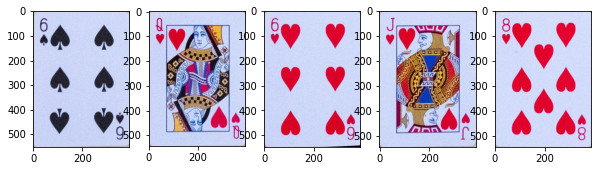

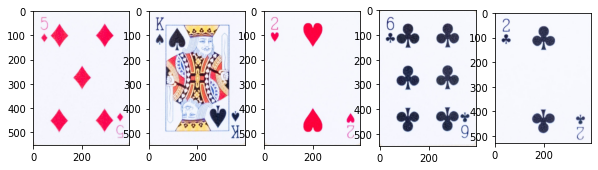

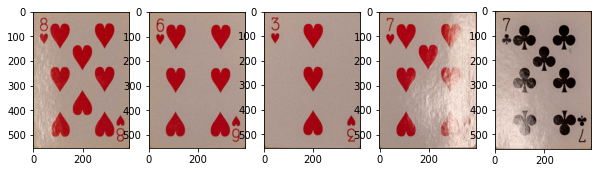

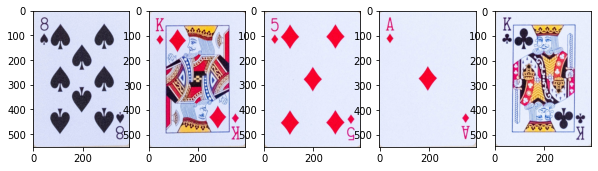

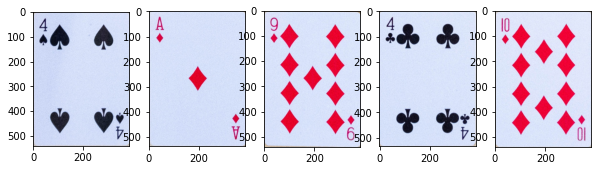

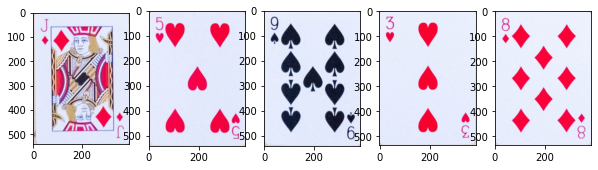

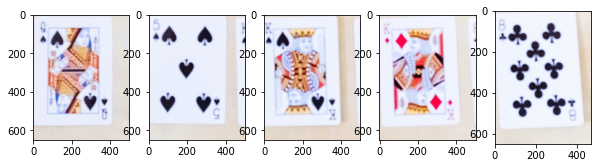

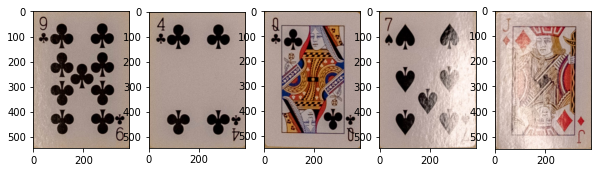

In [ ]:
TEST_ALGO_BOTTOM = False
if TEST_ALGO_BOTTOM:
    for file_path in train_images_crop:
        im = open_image(file_path)
        # As output you get the image of the card 
        bottom_cards_framed = identify_bottom_cards(im, plot_verbose_end = True)
    

# TODO / DISCUSS:
- Take care of blurr ?
- ALl images that are correct have the same size, what to do with others (slightly larger)

### Algo 2: Chips

Idea:
- use the circle Hough transform to identify the chips
- detect regions with overlapping chips
- determine the color of each chip

In [26]:
#plt.imshow(cropped_image_chips)

In [27]:
from collections import defaultdict

def chips(image):
    """Given the image of the center of the table, detects and counts the chips of each color.
    Returns a dict-like with the number of chip for the name of each color"""
    w, h = image.shape[:2]
    
    # Detect the edges with a Canny filter
    edges = canny_filter(basic_processing(image, 25), low_thresh=80, high_thresh=120, aperature_size=5)

    # Find circles with the Hough transform for circles. We know that the radius of the chips is about 122 pixels
    circles = cv.HoughCircles(edges, method=cv.HOUGH_GRADIENT, dp=5, minDist=90, param2=200, minRadius=115, maxRadius=125)
    
    if circles is None:
        centers = []
    else:
        # We're only interested in the center since we know the radius
        centers = [(int(circle[0]), int(circle[1])) for circle in circles[0]]
        
    # Build a map of the number of overlapping chips
    chip_count_mask = np.zeros((w, h), dtype=np.uint8)
    
    for center in centers:
        mask_to_add = np.zeros((w, h), dtype=np.uint8)
        cv.circle(mask_to_add, center, 123, 1, -1)
        chip_count_mask += mask_to_add
    
    overlap_mask = chip_count_mask <= 1
    
    # Compute the mean color of the table (region without chips) in LAB colorspace as a reference for the exposure
    table_color = np.ma.masked_array(cv.cvtColor(image, cv.COLOR_RGB2LAB), mask=np.broadcast_to(np.expand_dims(chip_count_mask != 0, 2), image.shape)).mean(axis=(0,1))
    
    # We use a small circular area around the center of each chip to detect the color.
    RADIUS = 60
    mask = np.zeros((2*RADIUS+1, 2*RADIUS+1), dtype=float)
    cv.circle(mask, (RADIUS, RADIUS), RADIUS, 1., -1)
    mask = mask.astype(bool)
    
    nb_chips = defaultdict(lambda: 0)
    
    for y, x in centers:
        # Copy the mask so we can modify it
        center_mask = mask.copy()
        
        # Region to crop
        x_min = x - RADIUS
        y_min = y - RADIUS
        x_max = x + RADIUS + 1
        y_max = y + RADIUS + 1
        
        # Boundary conditions
        if x_min < 0:
            center_mask = center_mask[-x_min:, :]
            x_min = 0
        if y_min < 0:
            center_mask = center_mask[:, -y_min:]
            y_min = 0
        if x_max > w:
            center_mask = center_mask[:w-x_max, :]
            x_max = w
        if y_max > h:
            center_mask = center_mask[:, :h-y_max]
            y_max = h
            
        # Crop the relevant region of the image
        center_image = image[x_min:x_max, y_min:y_max, :]
        # Mask the parts where chips overlap since the chip we observe might be behind
        center_mask &= overlap_mask[x_min:x_max, y_min:y_max]
        
        center_image = cv.cvtColor(center_image, cv.COLOR_RGB2LAB)
        
        mean_color = np.ma.masked_array(center_image, mask=np.broadcast_to(np.expand_dims(~center_mask, 2), center_image.shape)).mean(axis=(0,1))
        
        color_diff = mean_color - table_color
        
        if mean_color[1] > 150:
            nb_chips["CR"] += 1
        elif color_diff[0] > -10:
            nb_chips["CW"] += 1
        elif color_diff[1] < -15:
            nb_chips["CG"] += 1
        elif mean_color[2] < 100 or (color_diff[2] < -30 and mean_color[0] > 55):
            nb_chips["CB"] += 1
        else:
            nb_chips["CK"] += 1
            
    return nb_chips

In [28]:
test_chips = False
if test_chips:
    train_images_crop = glob("../project_data/train_crop/*.jpg")
    for image_file in train_images_crop:
        im = open_image(image_file)
        cropped_image_chips = im[950:2600, 900:2500]
        for color, nb in chips(cropped_image_chips).items():
            print(nb, color)
        
        plt.figure()
        plt.imshow(cropped_image_chips)
        plt.show()


In [29]:
im = open_image("../project_data/image_setup/chips.jpg")
im = crop_reframe_image(im)[950:2600, 900:2500]
chips(im)

defaultdict(<function __main__.chips.<locals>.<lambda>()>,
            {'CK': 1, 'CG': 1, 'CW': 1, 'CB': 1, 'CR': 1})

In [23]:
def process_image(image) -> dict:
    """
    Process image and return information. To return the value of the cards we use 
    the following format: {number}{color}. Where 
        - color is either (D)imanond, (H)eart, (S)pade, (C)lub
        - number is either 2-10, (J)ack, (Q)ueen, (K)ing. A(s).
            
    Parameters
    ----------
    image:
        Input image to process

    Returns
    -------
    results:
        - T1 (str): String code of the first card of the flop (far left) 
        - T2 (str): String code of the second card of the flop
        - T3 (str): String code of the third card of the flop
        - T4 (str): String code of the turn
        - T5 (str): String code of the river
        - P11 (str or int): String code of player 1 card 1. Should be 0 if player 1 is not Playing.
        - P12 (str or int): String code of player 1 card 2. Should be 0 if player 1 is not Playing.
        - P21 (str or int): String code of player 2 card 1. Should be 0 if player 2 is not Playing.
        - P22 (str or int): String code of player 2 card 2. Should be 0 if player 2 is not Playing.
        - P31 (str or int): String code of player 3 card 1. Should be 0 if player 3 is not Playing.
        - P32 (str or int): String code of player 3 card 2. Should be 0 if player 3 is not Playing.
        - P41 (str or int): String code of player 4 card 1. Should be 0 if player 4 is not Playing.
        - P42 (str or int): String code of player 4 card 2. Should be 0 if player 4 is not Playing.
        - CR (int): Number of (r)ed chips in the pot
        - CG (int): Number of (g)reen chips in the pot
        - CB (int): Number of (b)lue chips in the pot
        - CK (int): Number of blac(k) chips in the pot
        - CW (int): Number of (w)hite chips in the pot
        
    Examples
    --------
    - QH: Queen of hearths
    - 10S: 10 of spades
    - AC: Ace f clubs

    """
    
    # TODO: Amazing student code
    
    dummy_results = {
        # Flop, river and turn
        "T1": "2C", "T2": "AH", "T3": "8D", "T4": "JC", "T5": "JS",
        # Player cards
        "P11": '2H' , "P12": '3C', "P21": 'KS', "P22": "QS", "P31": "KD", "P32":"5S" , "P41": "7H", "P42": "8H",
        # Chips
         "CR": 1, "CG": 1, "CB": 1,"CK": 5, "CW": 0
    }
    return dummy_results


Working example

In [24]:
## load train size dataset
path_data = "../project_data/train"
group_id = 0

In [25]:
## load train size dataset
train_size = np.loadtxt(os.path.join(path_data, "train_size.txt")).astype(int)
print("Size of trainset:\n\t{}".format(train_size))

# Load images from folder
game_results = {}

# Evaluate three images
games_id = [0,3]  # to evaluate  three images

for i in games_id :
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
    # open the image
    im = PIL.Image.open(file)
    # Process the image
    results = process_image(image=im)
    # Append result to array
    game_results[i] = results

# Outputs prediction of game 0
print("Prediciton game:\n\t{}: {}".format(0, game_results[0]))#overlay

Size of trainset:
	28
Prediciton game:
	0: {'T1': '2C', 'T2': 'AH', 'T3': '8D', 'T4': 'JC', 'T5': 'JS', 'P11': '2H', 'P12': '3C', 'P21': 'KS', 'P22': 'QS', 'P31': 'KD', 'P32': '5S', 'P41': '7H', 'P42': '8H', 'CR': 1, 'CG': 1, 'CB': 1, 'CK': 5, 'CW': 0}


In [26]:
# Saving results
file_results = save_results(results=game_results, groupid=group_id)

NameError: name 'save_results' is not defined

In [ ]:
# Checking the results were loaded correctly
loaded_results = load_results(file_results)
print(loaded_results.keys())

# Evaluation and Debugging

In [ ]:
# Read training data
game_labels = pd.read_csv('../project_data/train/train_labels.csv')
game_labels = game_labels.fillna('0')
game_labels

In [ ]:
# Evaluate
eval_listof_games( game_results , game_labels , game_id = games_id)

In [ ]:
# Debug
debug_listof_games( game_results , game_labels, game_id = games_id)